#Assignment4: Excercise1

Note: According to the Nyquist theorem, the sampling rate must be at least twice the highest frequency in the signal to avoid aliasing. For DTMF tones:
The highest frequency is 1477 Hz (the maximum column frequency).

2×1477=2954 Hz is the minimum required sampling rate.
The sampling rate is fixed to 8000 Hz due to the **instructor's advice**. An 8000 Hz rate easily satisfies this criterion and leaves room for practical implementation.
    (but it is adjustable so one can change it to see the differance)


In [65]:
#Import usefull libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram

##Part (a)

Generating DTMF Tones

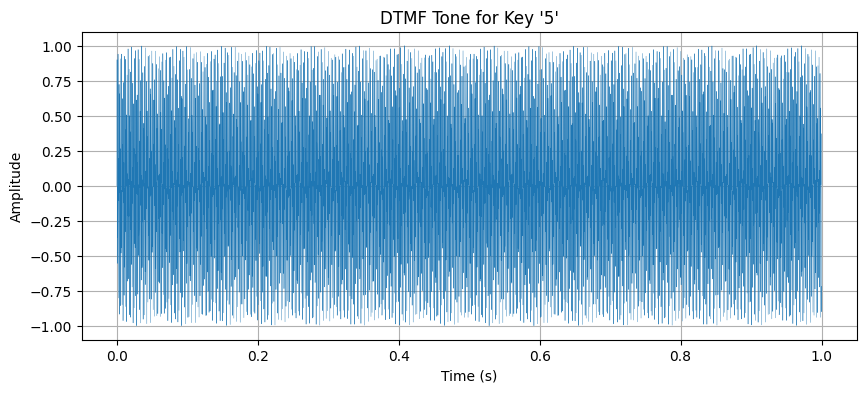

In [66]:
def gentone(key, duration=1.0, sampling_rate=8000):
    """
    Generate the DTMF tone for a given key on the telephone keypad.
    Args:
        key (str): The key pressed ('0'-'9', '*', '#').
        duration (float): Duration of the tone in seconds.
        sampling_rate (int): Sampling rate in Hz.
    Returns:
        np.ndarray: Time-domain signal.
        np.ndarray: Time array.
    """
    # Define the DTMF frequencies
    row_freqs = [697, 770, 852, 941]
    col_freqs = [1209, 1336, 1477]
    keypad = [
        ['1', '2', '3'],
        ['4', '5', '6'],
        ['7', '8', '9'],
        ['*', '0', '#']
    ]

    # Find the key position
    for i, row in enumerate(keypad):
        if key in row:
            row_index = i
            col_index = row.index(key)
            break

    # Get the corresponding frequencies
    fr = row_freqs[row_index]
    fc = col_freqs[col_index]

    # Time array
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    # Generate the tone
    tone = (np.sin(2 * np.pi * fr * t) + np.sin(2 * np.pi * fc * t)) / 2
    return tone, t

# Example: Generate tone for key '5'
tone, t = gentone('5', 1,8000)

# Plot the tone
plt.figure(figsize=(10, 4))
plt.plot(t, tone,linewidth=0.3)
plt.title("DTMF Tone for Key '5'")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

##Part(b)

Applying FFT

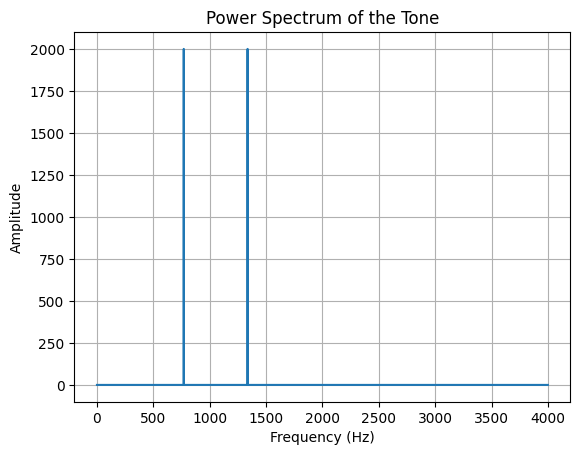

Expected Row Frequency: 770
Detected Row Frequency: 770.0
Expected Column Frequency: 1336
Detected Column Frequency: 1336.0
✔️ Detected frequencies match the expected frequencies.


In [67]:
def analyze_tone_with_verification(tone, expected_row_freq, expected_col_freq,
                                   sampling_rate=8000):
    """
    Apply FFT to the generated tone, plot the power spectrum, and verify the detected frequencies.
    Args:
        tone (np.ndarray): Time-domain signal.
        expected_row_freq (float): Expected row frequency for the tone.
        expected_col_freq (float): Expected column frequency for the tone.
        sampling_rate (int): Sampling rate in Hz.
    """
    # FFT computation
    N = len(tone)
    yf = fft(tone)
    xf = fftfreq(N, 1 / sampling_rate)

    # Power spectrum
    power_spectrum = np.abs(yf[:N//2])
    freqs = xf[:N//2]

    # Detect peaks (dominant frequencies)
    threshold = 0.1 * max(power_spectrum)
    detected_freqs = freqs[power_spectrum > threshold]

    # Plot power spectrum
    plt.plot(freqs, power_spectrum)
    plt.title("Power Spectrum of the Tone")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # Verify frequencies
    row_detected = min(detected_freqs, key=lambda x: abs(x - expected_row_freq))
    col_detected = min(detected_freqs, key=lambda x: abs(x - expected_col_freq))

    print("Expected Row Frequency:", expected_row_freq)
    print("Detected Row Frequency:", row_detected)
    print("Expected Column Frequency:", expected_col_freq)
    print("Detected Column Frequency:", col_detected)

    # Check if the detected frequencies match the expected ones
    row_correct = abs(row_detected - expected_row_freq) < 1  # Allow small tolerance
    col_correct = abs(col_detected - expected_col_freq) < 1

    if row_correct and col_correct:
        print("✔️ Detected frequencies match the expected frequencies.")
    else:
        print("❌ Detected frequencies do NOT match the expected frequencies.")

# Example: Generate tone for key '5' and verify
tone, _ = gentone('5')
analyze_tone_with_verification(tone, expected_row_freq=770, expected_col_freq=1336)


##Part (c)

 Generating a 2-Digit Signal with Noise

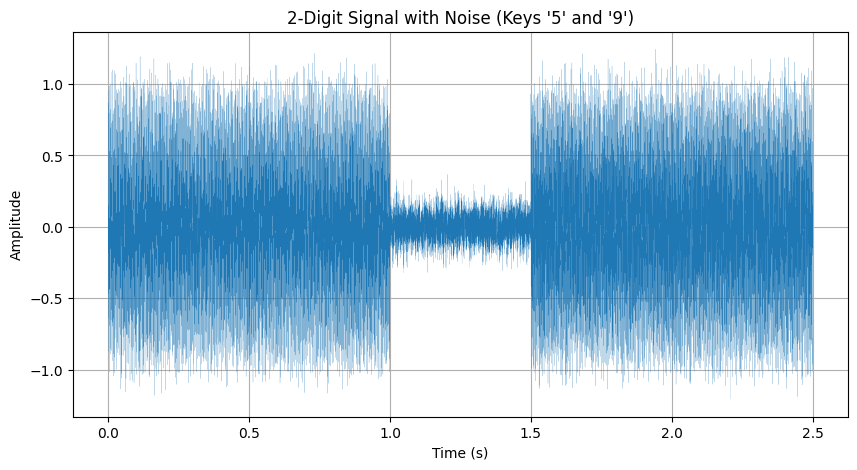

In [68]:
def two_digit_signal(key1, key2, delay=0.5, duration=1.0, noise_level=0.1, sampling_rate=8000):
    """
    Generate a 2-digit DTMF signal with noise.
    Args:
        key1, key2 (str): The keys pressed ('0'-'9', '*', '#').
        delay (float): Delay between the two tones in seconds.
        duration (float): Duration of each tone in seconds.
        noise_level (float): Standard deviation of added noise.
        sampling_rate (int): Sampling rate in Hz.
    Returns:
        np.ndarray: Combined signal.
        np.ndarray: Time array.
    """
    tone1, t1 = gentone(key1, duration, sampling_rate)
    tone2, t2 = gentone(key2, duration, sampling_rate)
    silence = np.zeros(int(delay * sampling_rate))

    combined_signal = np.concatenate([tone1, silence, tone2])
    noise = np.random.normal(0, noise_level, len(combined_signal))
    combined_signal += noise

    t = np.linspace(0, duration * 2 + delay, len(combined_signal), endpoint=False)
    return combined_signal, t

# Example: Generate signal for keys '5' and '9'
plt.figure(figsize=(10, 5))
#With noise
signal, t = two_digit_signal('5', '9')
plt.plot(t, signal,linewidth=0.1)
plt.title("2-Digit Signal with Noise (Keys '5' and '9')")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


##Part(d)

Short-Time Fourier Transform (STFT)

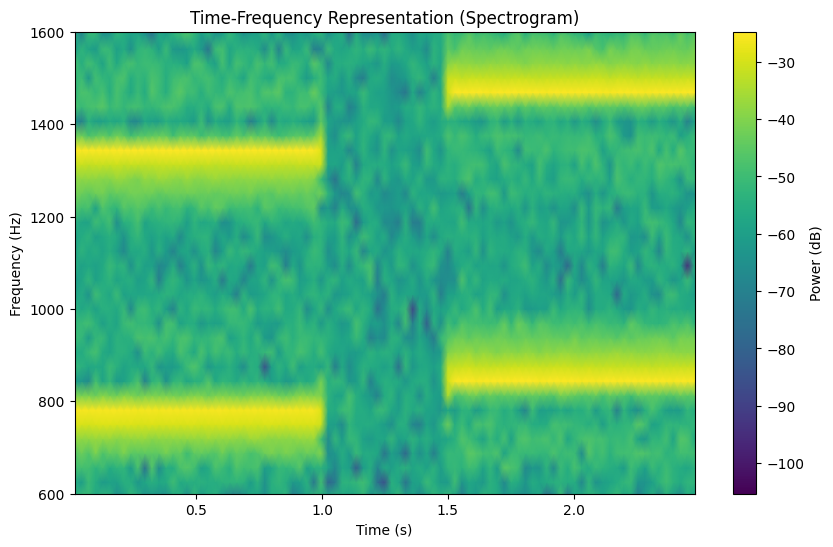

In [69]:
# Example: Generate a 2-digit signal and analyze it
sampling_rate=8000 #Hz
#With noise
signal, t = two_digit_signal('5', '9')  # Use '5' and '9' as an example
# Perform STFT
f, t, Sxx = spectrogram(signal, sampling_rate)
# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.title("Time-Frequency Representation (Spectrogram)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power (dB)")
plt.ylim(600, 1600)  # Focus on DTMF frequency range
plt.show()


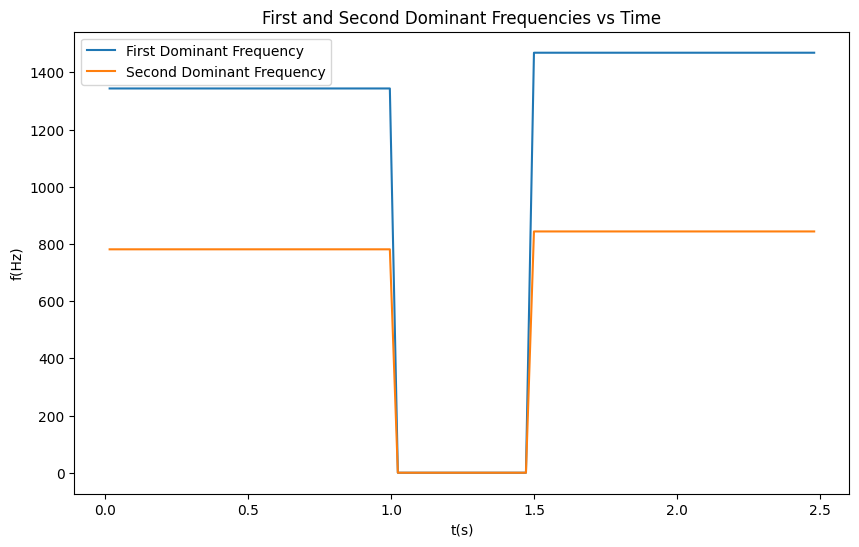

In [70]:
# Set every element of Sxx which has the value <= 0.1 of the max value to zero
threshold = 0.1 * np.max(Sxx)
Sxx[Sxx <= threshold] = 0

def find2maxindex(ls):
  """
  Finds the indices of the two largest elements in a list.
  Args:
      ls (list): The input list.
  Returns:
      tuple: Indices of the two largest elements.
  """
  imax1=np.argmax(ls)
  ls[imax1]=0
  imax2=np.argmax(ls)
  return imax1,imax2

# Initialize arrays to store the first and second max frequencies
fdf = np.zeros(len(t)) #First dominant frequencies
sdf = np.zeros(len(t)) # Second dominant frequencies

for i in range(len(t)):
    imax1,imax2=find2maxindex(list(Sxx[:,i]))
    fdf[i]=f[imax1]#frequency1
    if fdf[i] < 1000:
        sdf[i] = fdf[i]
        fdf[i] = f[imax2]
    else:
        sdf[i] = f[imax2]
# Plot the first and second maximum frequencies vs time
plt.figure(figsize=(10, 6))
plt.plot(t, fdf, label='First Dominant Frequency')
plt.plot(t, sdf, label='Second Dominant Frequency')
plt.title('First and Second Dominant Frequencies vs Time')
plt.xlabel('t(s)')
plt.ylabel('f(Hz)')
plt.legend()
plt.show()

In [72]:
from collections import Counter
def find_frequencies(fdf,sdf,nd):#nd=number of digits
    # Remove zeros
    fdfnz = [x for x in fdf if x != 0]
    sdfnz= [x for x in sdf if x != 0]
    counterfdf = Counter(fdfnz)
    countersdf = Counter(sdfnz)
    filtered_fdf = [x for x in fdfnz if counterfdf[x] > 1]
    filtered_sdf = [x for x in sdfnz if countersdf[x] > 1]
    final_fdf=list(dict.fromkeys(filtered_fdf))
    final_sdf=list(dict.fromkeys(filtered_sdf))
    # Find f_r and f_c
    nd=int(nd)
    corfreq=np.zeros((2,nd)) #Corresponding frequencies
    corfreq[0,:]=final_fdf
    corfreq[1,:]=final_sdf
    return corfreq
# Output the results
corfreq=find_frequencies(fdf,sdf,2)
print("For '5' f_c=",corfreq[0,0])
print("For '5' f_r=",corfreq[1,0])
print("For '9' f_c=",corfreq[0,1])
print("For '9' f_r=",corfreq[1,1])

For '5' f_c= 1343.75
For '5' f_r= 781.25
For '9' f_c= 1468.75
For '9' f_r= 843.75


**For digit '5':**

$f_{r2}=770$ and $f_{c2}=1336$ and here we are detecting close values.

**For digit '9':**

$f_{r2}=852$ and $f_{c2}=1477$ and here we are detecting close values.


##Part(e)

Analyzing phone.dat

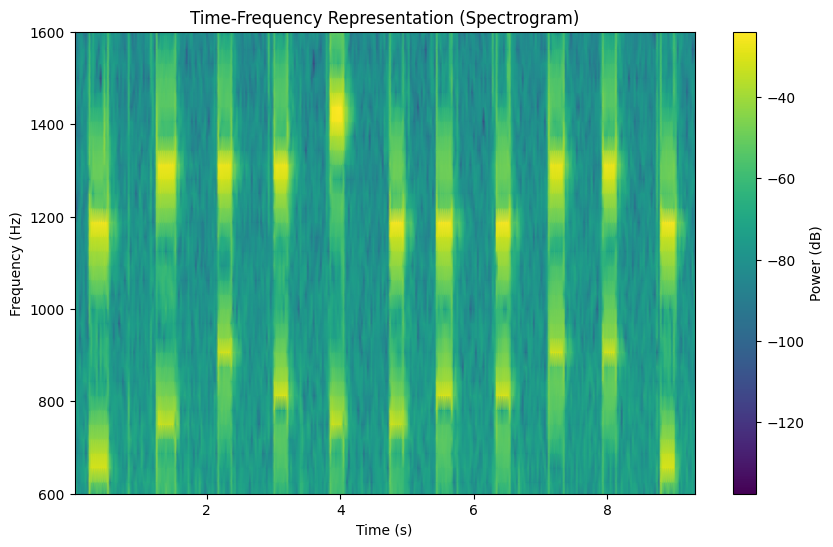

In [73]:
signal = np.loadtxt("phone.dat")
# Perform STFT
f, t, Sxx = spectrogram(signal, sampling_rate )
# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.title("Time-Frequency Representation (Spectrogram)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power (dB)")
plt.ylim(600, 1600)  # Focus on DTMF frequency range
plt.show()

based on this spectrogram we have 11 segments.

In [75]:
def adjust_sampling_rate(observed_freqs, dtmf_freqs, initial_sampling_rate=8000):
    """
    Adjust the sampling rate to match observed frequencies to DTMF frequencies.
    Args:
        observed_freqs (list): Frequencies obtained from FFT.
        dtmf_freqs (list): Known DTMF frequencies.
        initial_sampling_rate (int): Initial guess for the sampling rate.
    Returns:
        float: Adjusted sampling rate.
    """
    # Compute the scaling factor for the sampling rate
    scaling_factors = [dtmf_freq / obs_freq for dtmf_freq in dtmf_freqs for obs_freq in observed_freqs if abs(dtmf_freq - obs_freq) < 50]
    if scaling_factors:
        avg_scaling_factor = np.mean(scaling_factors)
        return initial_sampling_rate * avg_scaling_factor
    return initial_sampling_rate


def decode_phone_number_with_adjustment(file_path, dtmf_row_freqs, dtmf_col_freqs, initial_sampling_rate=8000):
    """
    Decode the phone number from the recorded signal, adjusting the sampling rate.
    Args:
        file_path (str): Path to the .dat file.
        dtmf_row_freqs (list): Known row frequencies of the keypad.
        dtmf_col_freqs (list): Known column frequencies of the keypad.
        initial_sampling_rate (int): Initial sampling rate in Hz.
    Returns:
        str: Decoded phone number.
    """
    # Load the signal
    signal = np.loadtxt(file_path)
    num_segments = 11  # I choosed this based on the STFT
    segment_length = len(signal) // num_segments
    # segment_length = int(initial_sampling_rate * 0.5)  # Assuming ~0.5s per tone
    phone_number = ""
    adjusted_sampling_rate = initial_sampling_rate

    for i in range(0, len(signal), segment_length):
        segment = signal[i:i + segment_length]
        if len(segment) < segment_length:
            break

        # Apply FFT
        yf = fft(segment)
        xf = fftfreq(len(segment), 1 / adjusted_sampling_rate)
        observed_freqs = xf[:len(segment)//2][np.abs(yf[:len(segment)//2]) > 0.1 * max(np.abs(yf))]

        # Adjust the sampling rate
        adjusted_sampling_rate = adjust_sampling_rate(observed_freqs, dtmf_row_freqs + dtmf_col_freqs, adjusted_sampling_rate)

        # Match frequencies to keypad
        detected_row = min(dtmf_row_freqs, key=lambda x: min(abs(observed_freqs - x)))
        detected_col = min(dtmf_col_freqs, key=lambda x: min(abs(observed_freqs - x)))

        keypad = [
            ['1', '2', '3'],
            ['4', '5', '6'],
            ['7', '8', '9'],
            ['*', '0', '#']
        ]
        row_index = dtmf_row_freqs.index(detected_row)
        col_index = dtmf_col_freqs.index(detected_col)
        phone_number += keypad[row_index][col_index]

    return phone_number, adjusted_sampling_rate

# Define DTMF frequencies
dtmf_row_freqs = [697, 770, 852, 941]
dtmf_col_freqs = [1209, 1336, 1477]

# Decode phone number
file_path = "phone.dat"  # Replace with the actual path
decoded_number, adjusted_sampling_rate = decode_phone_number_with_adjustment(
    file_path, dtmf_row_freqs, dtmf_col_freqs
)

print("Decoded Phone Number:", decoded_number)
print("Adjusted Sampling Rate:", adjusted_sampling_rate)


Decoded Phone Number: 15086477001
Adjusted Sampling Rate: 8275.87471090726


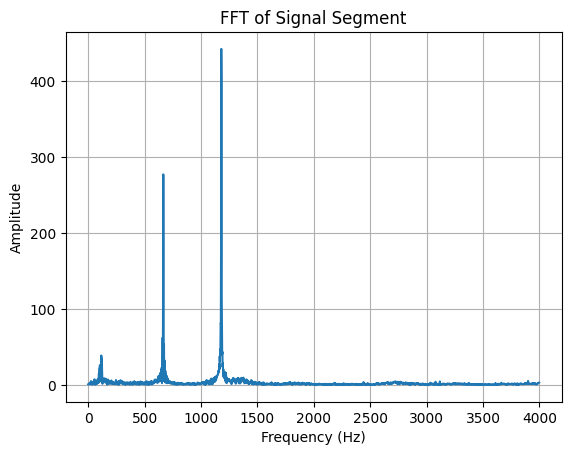

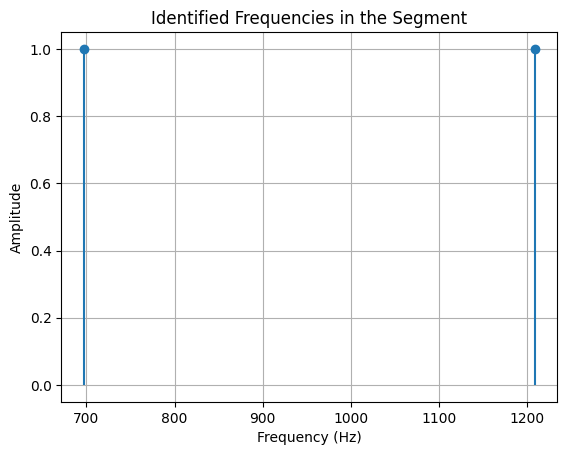

Observed Frequencies: [ 660.  664.  666.  668.  672. 1170. 1174. 1176. 1178. 1180. 1182. 1184.
 1186.]
Detected Row Frequency: 697
Detected Column Frequency: 1209
Adjusted Sampling Rate: 8269.766861032544


(697, 1209, 8269.766861032544)

In [79]:
def visualize_one_segment(signal, start_idx, segment_length, dtmf_row_freqs, dtmf_col_freqs, sampling_rate=8000):
    """
    Visualize the FFT and frequency matching for a single segment of the signal.
    Args:
        signal (np.ndarray): The full recorded signal.
        start_idx (int): Starting index of the segment.
        segment_length (int): Length of each segment (in samples).
        dtmf_row_freqs (list): Known row frequencies of the keypad.
        dtmf_col_freqs (list): Known column frequencies of the keypad.
        sampling_rate (int): Sampling rate in Hz.
    """
    # Extract the segment
    segment = signal[start_idx:start_idx + segment_length]

    # Apply FFT
    yf = fft(segment)
    xf = fftfreq(len(segment), 1 / sampling_rate)
    observed_freqs = xf[:len(segment)//2][np.abs(yf[:len(segment)//2]) > 0.1 * max(np.abs(yf))]

    # Plot the FFT results
    plt.plot(xf[:len(segment)//2], np.abs(yf[:len(segment)//2]))
    plt.title("FFT of Signal Segment")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # Adjust the sampling rate (based on observed frequencies)
    scaling_factors = [
        dtmf_freq / obs_freq
        for dtmf_freq in dtmf_row_freqs + dtmf_col_freqs
        for obs_freq in observed_freqs
        if abs(dtmf_freq - obs_freq) < 50
    ]
    avg_scaling_factor = np.mean(scaling_factors) if scaling_factors else 1.0
    adjusted_sampling_rate = sampling_rate * avg_scaling_factor

    # Identify the nearest row and column frequencies
    detected_row = min(dtmf_row_freqs, key=lambda x: min(abs(observed_freqs - x)))
    detected_col = min(dtmf_col_freqs, key=lambda x: min(abs(observed_freqs - x)))

    # Visualize detected frequencies
    plt.stem([detected_row, detected_col], [1, 1], basefmt=" ")
    plt.title("Identified Frequencies in the Segment")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # Print results
    print("Observed Frequencies:", observed_freqs)
    print("Detected Row Frequency:", detected_row)
    print("Detected Column Frequency:", detected_col)
    print("Adjusted Sampling Rate:", adjusted_sampling_rate)

    return detected_row, detected_col, adjusted_sampling_rate

# Example Usage
file_path = "phone.dat"  # Replace with actual path
dtmf_row_freqs = [697, 770, 852, 941]
dtmf_col_freqs = [1209, 1336, 1477]

# Load signal and visualize a single segment
signal = np.loadtxt(file_path)
sampling_rate = 8000
segment_length = int(sampling_rate * 0.5)  # Assuming ~0.5s per tone
start_idx = 0  # Analyze the first segment
visualize_one_segment(signal, start_idx, segment_length, dtmf_row_freqs, dtmf_col_freqs, sampling_rate)
